Importing Libraries 

In [6]:
#!pip install pandas numpy matplotlib seaborn scipy

# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Matplotlib is building the font cache; this may take a moment.


In [ ]:
#Merging the dataset 
df1 = pd.read_csv("../data/Citations updated.csv", encoding='ISO-8859-1') #citations
df2 = pd.read_csv("../data/reproducibility_stamp.csv", encoding='ISO-8859-1') #repStamp
merged_df = df1.merge(df2[['Title','DOI']], on ='Title', how='left',suffixes=('', '_from_Rep_Sta'))
merged_df['DOI'] = merged_df['DOI'].combine_first(merged_df['DOI_from_Rep_Sta'])
merged_df.head()
merged_df.drop(columns=['DOI_from_Rep_Sta'],inplace=True)
merged_df.to_csv(r'../data/merged_data.csv', index=False, encoding='ISO-8859-1')
#merged citations.csv with reproducibility_stamp, now the rows with a DOI are of reports with reproducibility stamps

In [ ]:
#Checking for null values, verifying data types 
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1400 entries, 0 to 1399
Data columns (total 26 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ï»¿Cites        1400 non-null   int64  
 1   Authors         1400 non-null   object 
 2   Title           1400 non-null   object 
 3   Year            1400 non-null   int64  
 4   Source          1398 non-null   object 
 5   Publisher       1391 non-null   object 
 6   ArticleURL      1337 non-null   object 
 7   CitesURL        1204 non-null   object 
 8   GSRank          1400 non-null   int64  
 9   QueryDate       1400 non-null   object 
 10  Type            278 non-null    object 
 11  DOI             88 non-null     object 
 12  ISSN            0 non-null      float64
 13  CitationURL     0 non-null      float64
 14  Volume          0 non-null      float64
 15  Issue           0 non-null      float64
 16  StartPage       0 non-null      float64
 17  EndPage         0 non-null      f

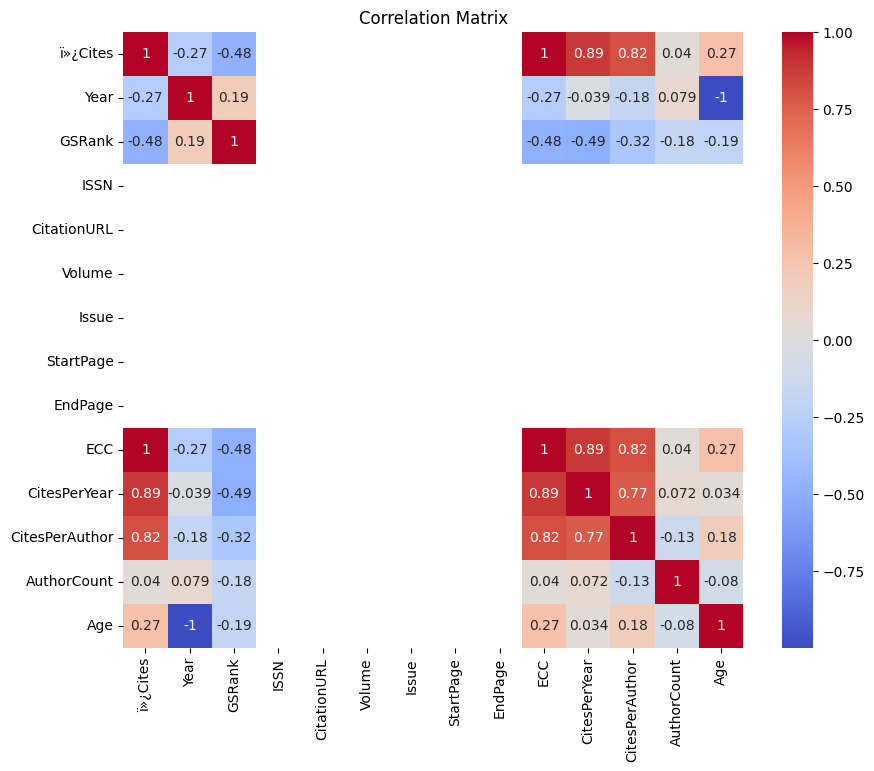

In [44]:
#Correlation matrix 
corr_matrix = merged_df.corr(numeric_only=True)

plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


Remove coloumns with no futher use

In [56]:

coloumns_to_drop = ['Year', 'Source', 'ArticleURL', 'CitesURL', 'ISSN', 'Volume', 'Issue', 'StartPage', 'EndPage', 'CitationURL', 'FullTextURL', 'RelatedURL']
merged_df.drop(columns=coloumns_to_drop, inplace=True, errors='ignore')


Create a binary variable for reproducbility stamp

In [57]:
merged_df['IsReproducible?'] = merged_df['DOI'].notnull().astype(int) # added a reproducible boolean
merged_df.to_csv('./test.csv', index=False, encoding='ISO-8859-1')

In [58]:
merged_df.isnull().sum()


ï»¿Cites              0
Authors               0
Title                 0
Publisher             9
GSRank                0
QueryDate             0
Type               1122
DOI                1312
CitesPerYear          0
CitesPerAuthor        0
AuthorCount           0
Age                   0
Abstract             64
IsReproducible?       0
dtype: int64

In [ ]:

from scipy.stats import mannwhitneyu

# Separate the two groups
reproducible = merged_df[merged_df['IsReproducible?'] == 1]['CitesPerYear']
non_reproducible = merged_df[merged_df['IsReproducible?'] == 0]['CitesPerYear']

# Perform the Mann-Whitney U Test
stat, p = mannwhitneyu(reproducible, non_reproducible)

print(f"U Statistic = {stat}")
print(f"P-value = {p}")

# Interpretation
if p < 0.05:
    print("Result: Significant difference between reproducible and non-reproducible papers 🚀")
else:
    print("Result: No significant difference detected ❗")


U Statistic = 53872.5
P-value = 0.29254470049819004
Result: No significant difference detected ❗


In [72]:
%pip install statsmodels


Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 9.9 MB 5.3 MB/s eta 0:00:01
     |████████████████████████████████| 232 kB 11.3 MB/s eta 0:00:01
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import statsmodels.api as sm

# Define features and target
X = merged_df[['IsReproducible?', 'AuthorCount', 'Age']]
X = sm.add_constant(X)  # Adds intercept
y = merged_df['CitesPerYear']

# Fit the model
model = sm.OLS(y, X).fit()

# Show summary
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:               ï»¿Cites   R-squared:                       0.076
Model:                            OLS   Adj. R-squared:                  0.074
Method:                 Least Squares   F-statistic:                     38.38
Date:                Sat, 05 Apr 2025   Prob (F-statistic):           7.88e-24
Time:                        14:38:29   Log-Likelihood:                -6488.4
No. Observations:                1400   AIC:                         1.298e+04
Df Residuals:                    1396   BIC:                         1.301e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -2.6850      2.284     

Boxplot: CitesPerYear vs Reproducibility

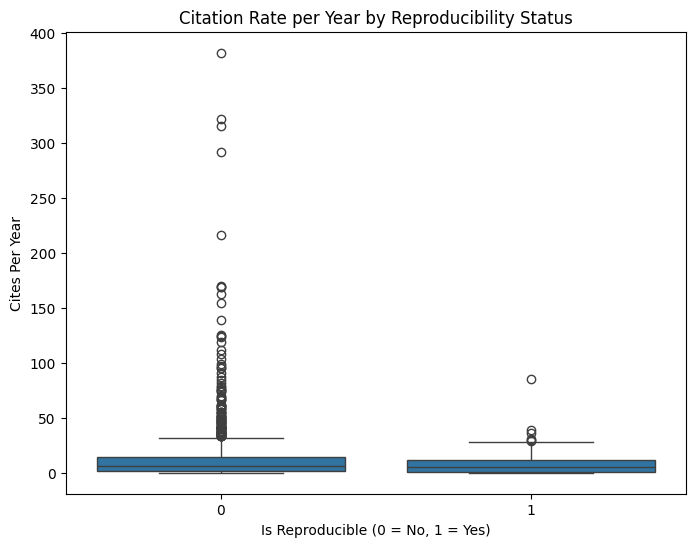

In [ ]:
plt.figure(figsize=(8,6))
sns.boxplot(data=merged_df, x='IsReproducible?', y='CitesPerYear')
plt.title('Citation Rate per Year by Reproducibility Status')
plt.xlabel('Is Reproducible (0 = No, 1 = Yes)')
plt.ylabel('Cites Per Year')
plt.show()


 Scatterplot: Age vs CitesPerYear, Colored by Reproducibility

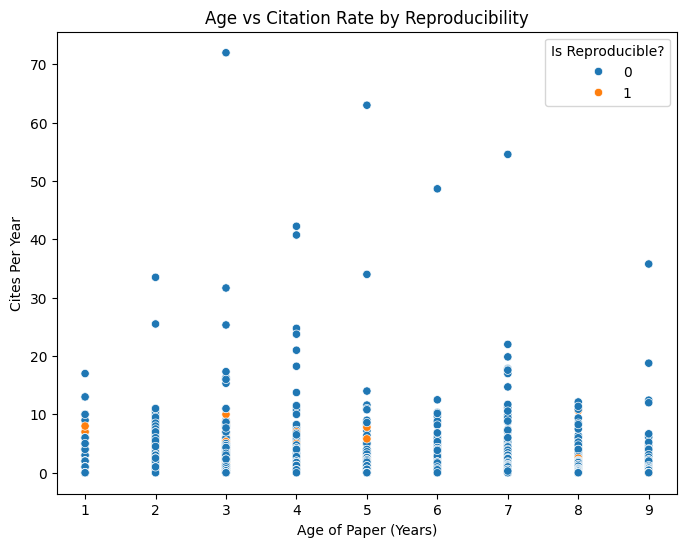

In [79]:
plt.figure(figsize=(8,6))
sns.scatterplot(data=merged_df, x='Age', y='CitesPerYear', hue='IsReproducible?')
plt.title('Age vs Citation Rate by Reproducibility')
plt.xlabel('Age of Paper (Years)')
plt.ylabel('Cites Per Year')
plt.legend(title='Is Reproducible?')
plt.show()


Barplot: Average CitesPerYear for Reproducible vs Non-Reproducible

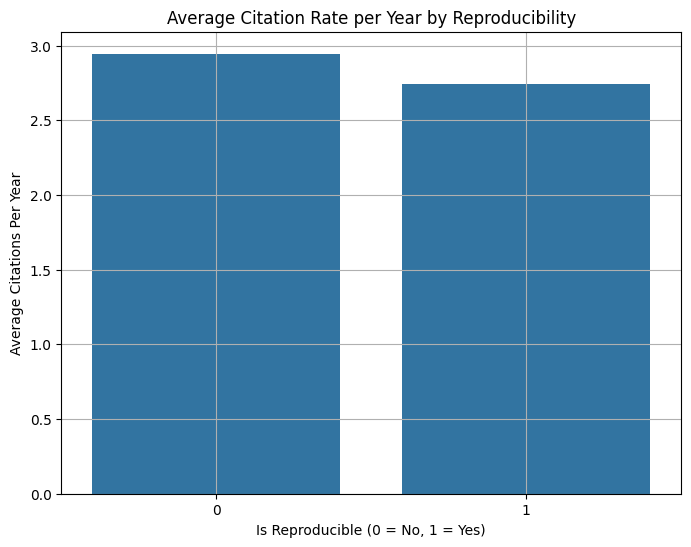

In [81]:
plt.figure(figsize=(8,6))
avg_cites = merged_df.groupby('IsReproducible?')['CitesPerYear'].mean().reset_index()

sns.barplot(data=avg_cites, x='IsReproducible?', y='CitesPerYear')
plt.title('Average Citation Rate per Year by Reproducibility')
plt.xlabel('Is Reproducible (0 = No, 1 = Yes)')
plt.ylabel('Average Citations Per Year')
plt.grid(True)
plt.show()


In [82]:
merged_df['CitesPerAuthorPerYear'] = merged_df['CitesPerYear'] / merged_df['AuthorCount']


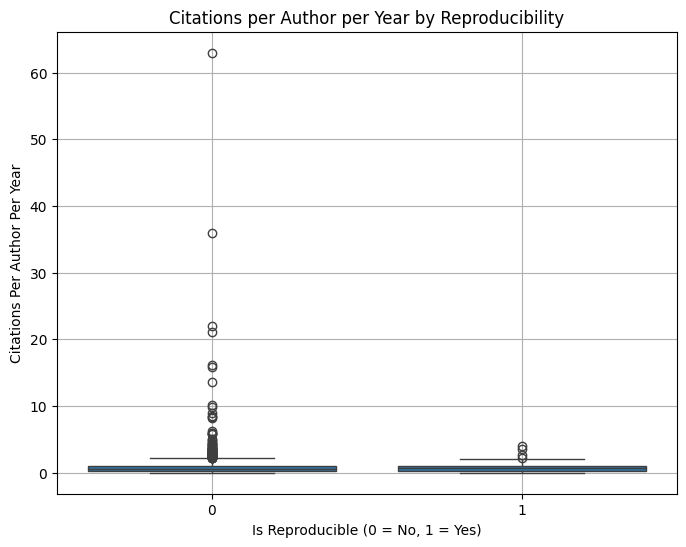

In [83]:

plt.figure(figsize=(8,6))
sns.boxplot(data=merged_df, x='IsReproducible?', y='CitesPerAuthorPerYear')
plt.title('Citations per Author per Year by Reproducibility')
plt.xlabel('Is Reproducible (0 = No, 1 = Yes)')
plt.ylabel('Citations Per Author Per Year')
plt.grid(True)
plt.show()


In [86]:
# Calculate 95th percentile value
q95 = merged_df['CitesPerAuthorPerYear'].quantile(0.95)

# Keep only rows below the 95th percentile
df_no_outliers = merged_df[merged_df['CitesPerAuthorPerYear'] <= q95]


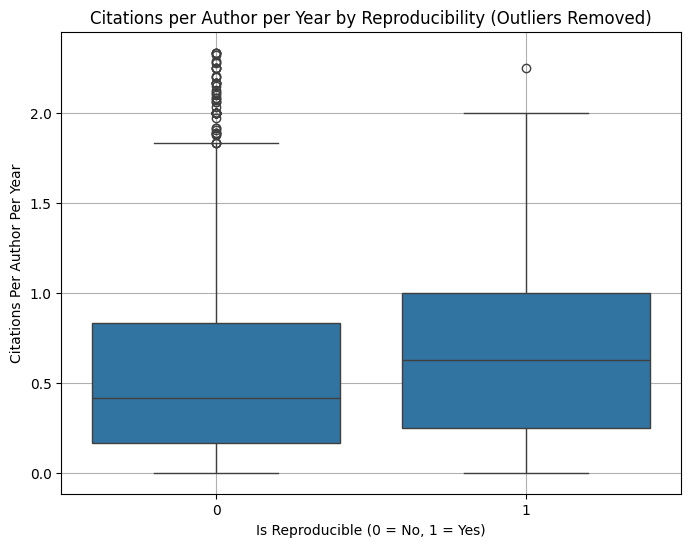

In [87]:
plt.figure(figsize=(8,6))
sns.boxplot(data=df_no_outliers, x='IsReproducible?', y='CitesPerAuthorPerYear')
plt.title('Citations per Author per Year by Reproducibility (Outliers Removed)')
plt.xlabel('Is Reproducible (0 = No, 1 = Yes)')
plt.ylabel('Citations Per Author Per Year')
plt.grid(True)
plt.show()
